# Fundamentals of Artificial Intelligence and Knowledge Representation
## Module 3
#### Università di Bologna 
Aprile 2022<br>
<br>
Davide Buldrini, Nicolò Donati, Guido Laudenzi<br>
<br>
#Body Performance
## Introduction
In this notebook, some of the tecniques described in the third module of the course Fundamentals of Artificial Intelligence and Knowledge Representation will be implemented, using a dataset from [Kaggle](https://www.kaggle.com) about body performance:


*   Dataset analysis and discovery of correlation between attributes.
*   Creation of the Bayesian Network using conditional probabilities.
*   Exact inference: Variable Elimination, queries.
*   Approximate inference and Sampling methods.
*   Markov Blanket.




In [ ]:
!pip install pgmpy

     |████████████████████████████████| 1.9 MB 6.4 MB/s 


In [ ]:
from google.colab import files
import numpy as np
import sklearn
import pandas as pd
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling
from pgmpy.sampling import GibbsSampling
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
files.upload()

Saving bodyPerformance.csv to bodyPerformance.csv


{'bodyPerformance.csv': b'age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class\n27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C\n25.0,M,165.0,55.8,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A\n31.0,M,179.6,78.0,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C\n32.0,M,174.5,71.1,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B\n28.0,M,173.8,67.7,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B\n36.0,F,165.4,55.4,22.0,64.0,119.0,23.8,21.0,27.0,153.0,B\n42.0,F,164.5,63.7,32.2,72.0,135.0,22.7,0.8,18.0,146.0,D\n33.0,M,174.9,77.2,36.9,84.0,137.0,45.9,12.3,42.0,234.0,B\n54.0,M,166.8,67.5,27.6,85.0,165.0,40.4,18.6,34.0,148.0,C\n28.0,M,185.0,84.6,14.4,81.0,156.0,57.9,12.1,55.0,213.0,B\n42.0,M,169.2,65.4,19.3,63.0,110.0,43.5,16.0,68.0,211.0,A\n57.0,F,153.0,49.0,20.9,69.0,106.0,21.5,30.0,0.0,90.0,D\n27.0,F,156.0,53.9,35.5,69.0,116.0,23.1,13.1,28.0,144.0,C\n22.0,M,175.7,67.9,11.3,71.0,103.0,52.5,19.2,55.0,232.0,C\n24.0,M,181.0,84.4,20.4,80.0,120.0

In [ ]:
dataset = pd.read_csv("bodyPerformance.csv")

##  Pre-processing
The imported dataset have 12 columns representing the different characteristics of the individuals who took part in the survey.<br> Some attributes were dropped in order to get a more manageable dataset to build a suitable Network.

In [ ]:
#Decreasing nodes to simplify the model
dataset = dataset.drop(['diastolic','systolic','sit and bend forward_cm'],axis=1)
dataset.head()

,age,gender,height_cm,weight_kg,body fat_%,gripForce,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,54.9,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,36.4,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,44.8,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,41.4,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,43.5,45.0,217.0,B


Some of the variables of the dataset are of type string, so they were mapped into discrete values.

In [ ]:
gender = {'M': 0, 'F': 1}
dataset['gender'] = dataset['gender'].map(gender)
classes = {'D':0,'C': 1, 'B': 2, 'A':3}
dataset['class'] = dataset['class'].map(classes)

The pairplots are meant to show the correlation between attributes of the dataset, so to create a more reliable graph for the Bayesian Network. 

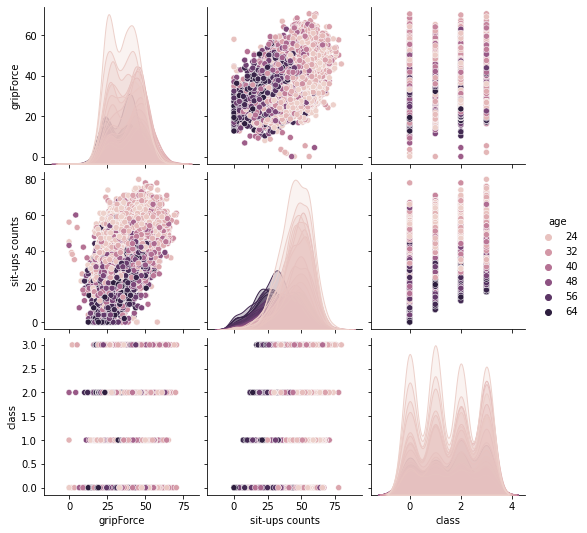

In [ ]:
sb.pairplot(dataset, vars=['gripForce','sit-ups counts','class'], hue='age')

According to the pairplot above, age seems to affect the sit-ups counts and the grip force.

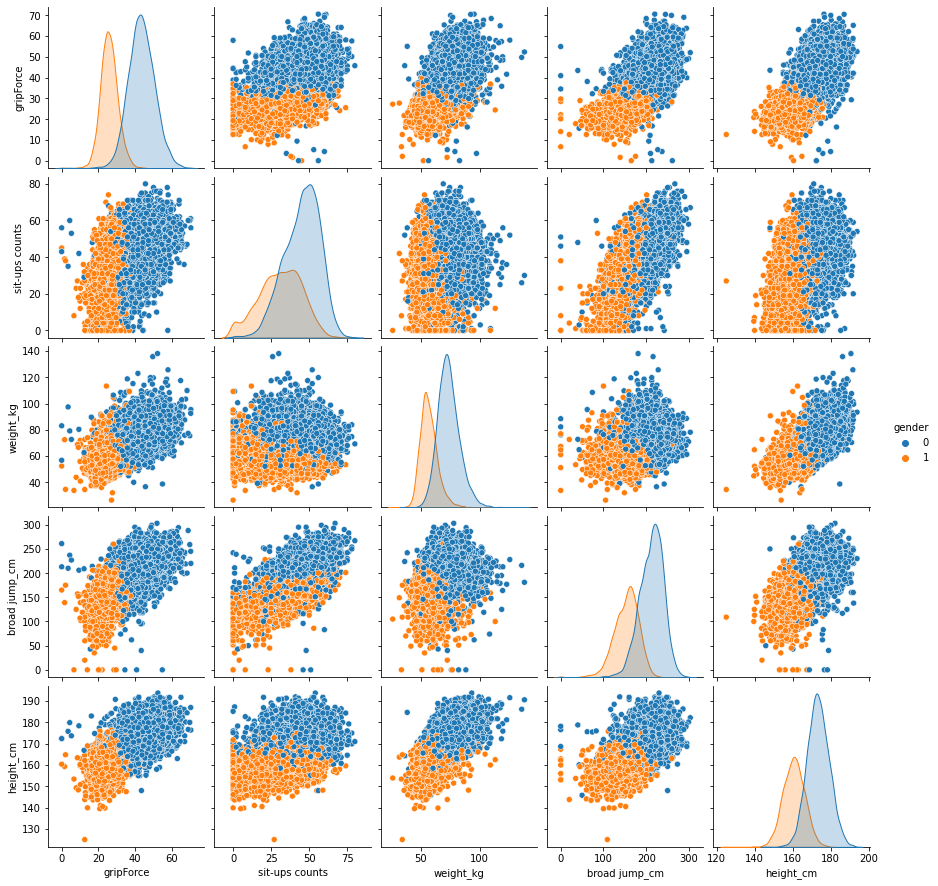

In [ ]:
sb.pairplot(dataset, vars=['gripForce','sit-ups counts','weight_kg', 'broad jump_cm', 'height_cm'], hue='gender')

Women are on average shorter than men, they have less grip force but the same performance in the sit ups count. Height seems to be proportional to weight and also to broad jump_cm, and that appears pretty reasonable.

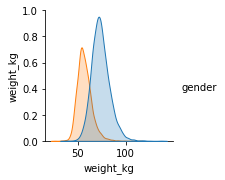

In [ ]:
sb.pairplot(dataset, vars=['weight_kg'], hue='gender')

# Clustering
The columns that are interesting have continuous data. In order to use this data for counting the conditional probabilities, it has to be discretized. The chosen discretization method is KMeans clustering.

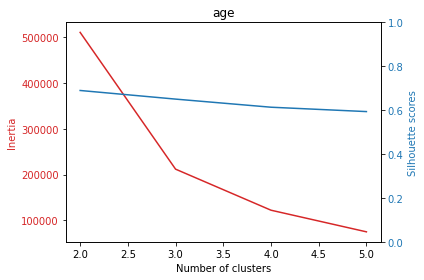

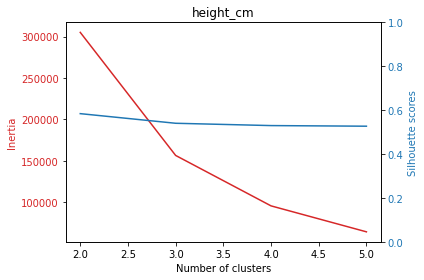

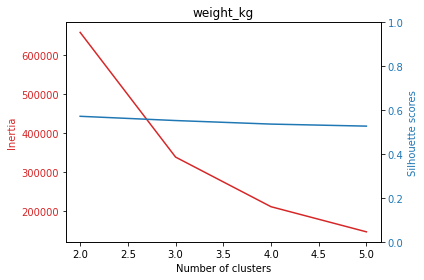

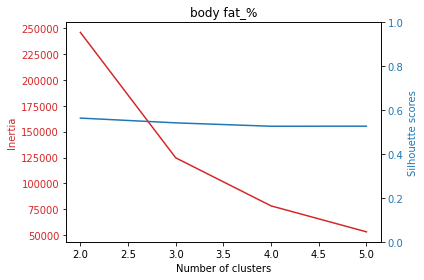

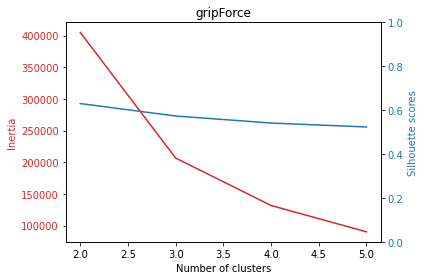

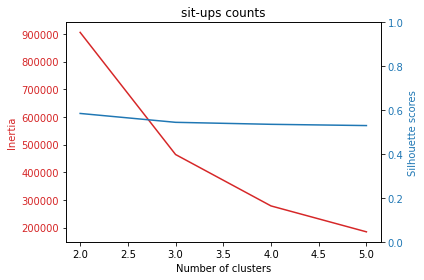

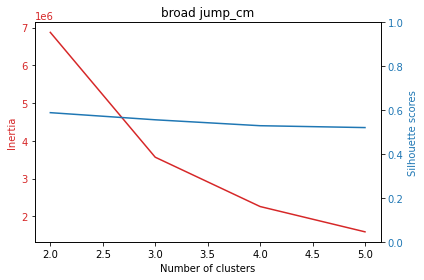

In [ ]:
clusters = [i for i in range(2,6)]
t = clusters

for k in ['age','height_cm','weight_kg','body fat_%','gripForce','sit-ups counts','broad jump_cm']:
    I,S=[],[]
    for i in clusters:
        k_means = KMeans(n_clusters=i).fit_predict(np.asarray(dataset.loc[:,k]).reshape(-1, 1))
        k1_means = KMeans(n_clusters=i).fit(np.asarray(dataset.loc[:,k]).reshape(-1, 1))
        I.append(k1_means.inertia_)
        S.append(silhouette_score(np.asarray(dataset.loc[:,k]).reshape(-1, 1), k_means))
    # Create some mock data
    data1 = I
    data2 = S

    fig, ax1 = plt.subplots()

    color = 'tab:red' 
    ax1.set_title(k)
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Inertia', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data2, color=color)
    ax2.set_ylim(ymin=0.0, ymax=1.0)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

Looking at the Silhouette scores and Inertia, it is possible to notice that all the columns are prone to clustering using 3 clusters.

In [ ]:
for k in ['age','height_cm','weight_kg','body fat_%','gripForce','sit-ups counts','broad jump_cm']:
    k_means = KMeans(n_clusters=3, random_state=42).fit_predict(np.asarray(dataset.loc[:,k]).reshape(-1, 1))

    j=[0,1,2]
    j.remove(k_means[pd.Series.idxmin(dataset[k])])
    j.remove(k_means[pd.Series.idxmax(dataset[k])])
  
    c = {k_means[pd.Series.idxmin(dataset[k])]: 0, j[0]: 1, k_means[pd.Series.idxmax(dataset[k])]:2}
    k_means = pd.Series(k_means).map(c)
    dataset[k]=k_means

print(dataset.head()) 

   age  gender  height_cm  weight_kg  body fat_%  gripForce  sit-ups counts  \
0    0       0          1          1           1          2               2   
1    0       0          1          0           0          1               2   
2    0       0          2          2           1          2               2   
3    0       0          2          1           0          1               2   
4    0       0          2          1           0          1               2   

   broad jump_cm  class  
0              2      1  
1              2      3  
2              1      1  
3              2      2  
4              2      2  


## Model description
From the pairplots, it is possible to derive some correlation between the attributes in our data. The Model is then created mixing the informations obtained from the graphs and some prior knowledge.

*   Age seem to affect the sit-ups counts and the grip force.
*   Women are on average shorter than men, they have a less grip force but the same performance in the sit-ups count.
* Height seems to be proportional to weight and also to broad jump.
* Gender influences the body fat %.
*  The performances in sit-ups counts, broad jump and grip force are relevant to infer the class.



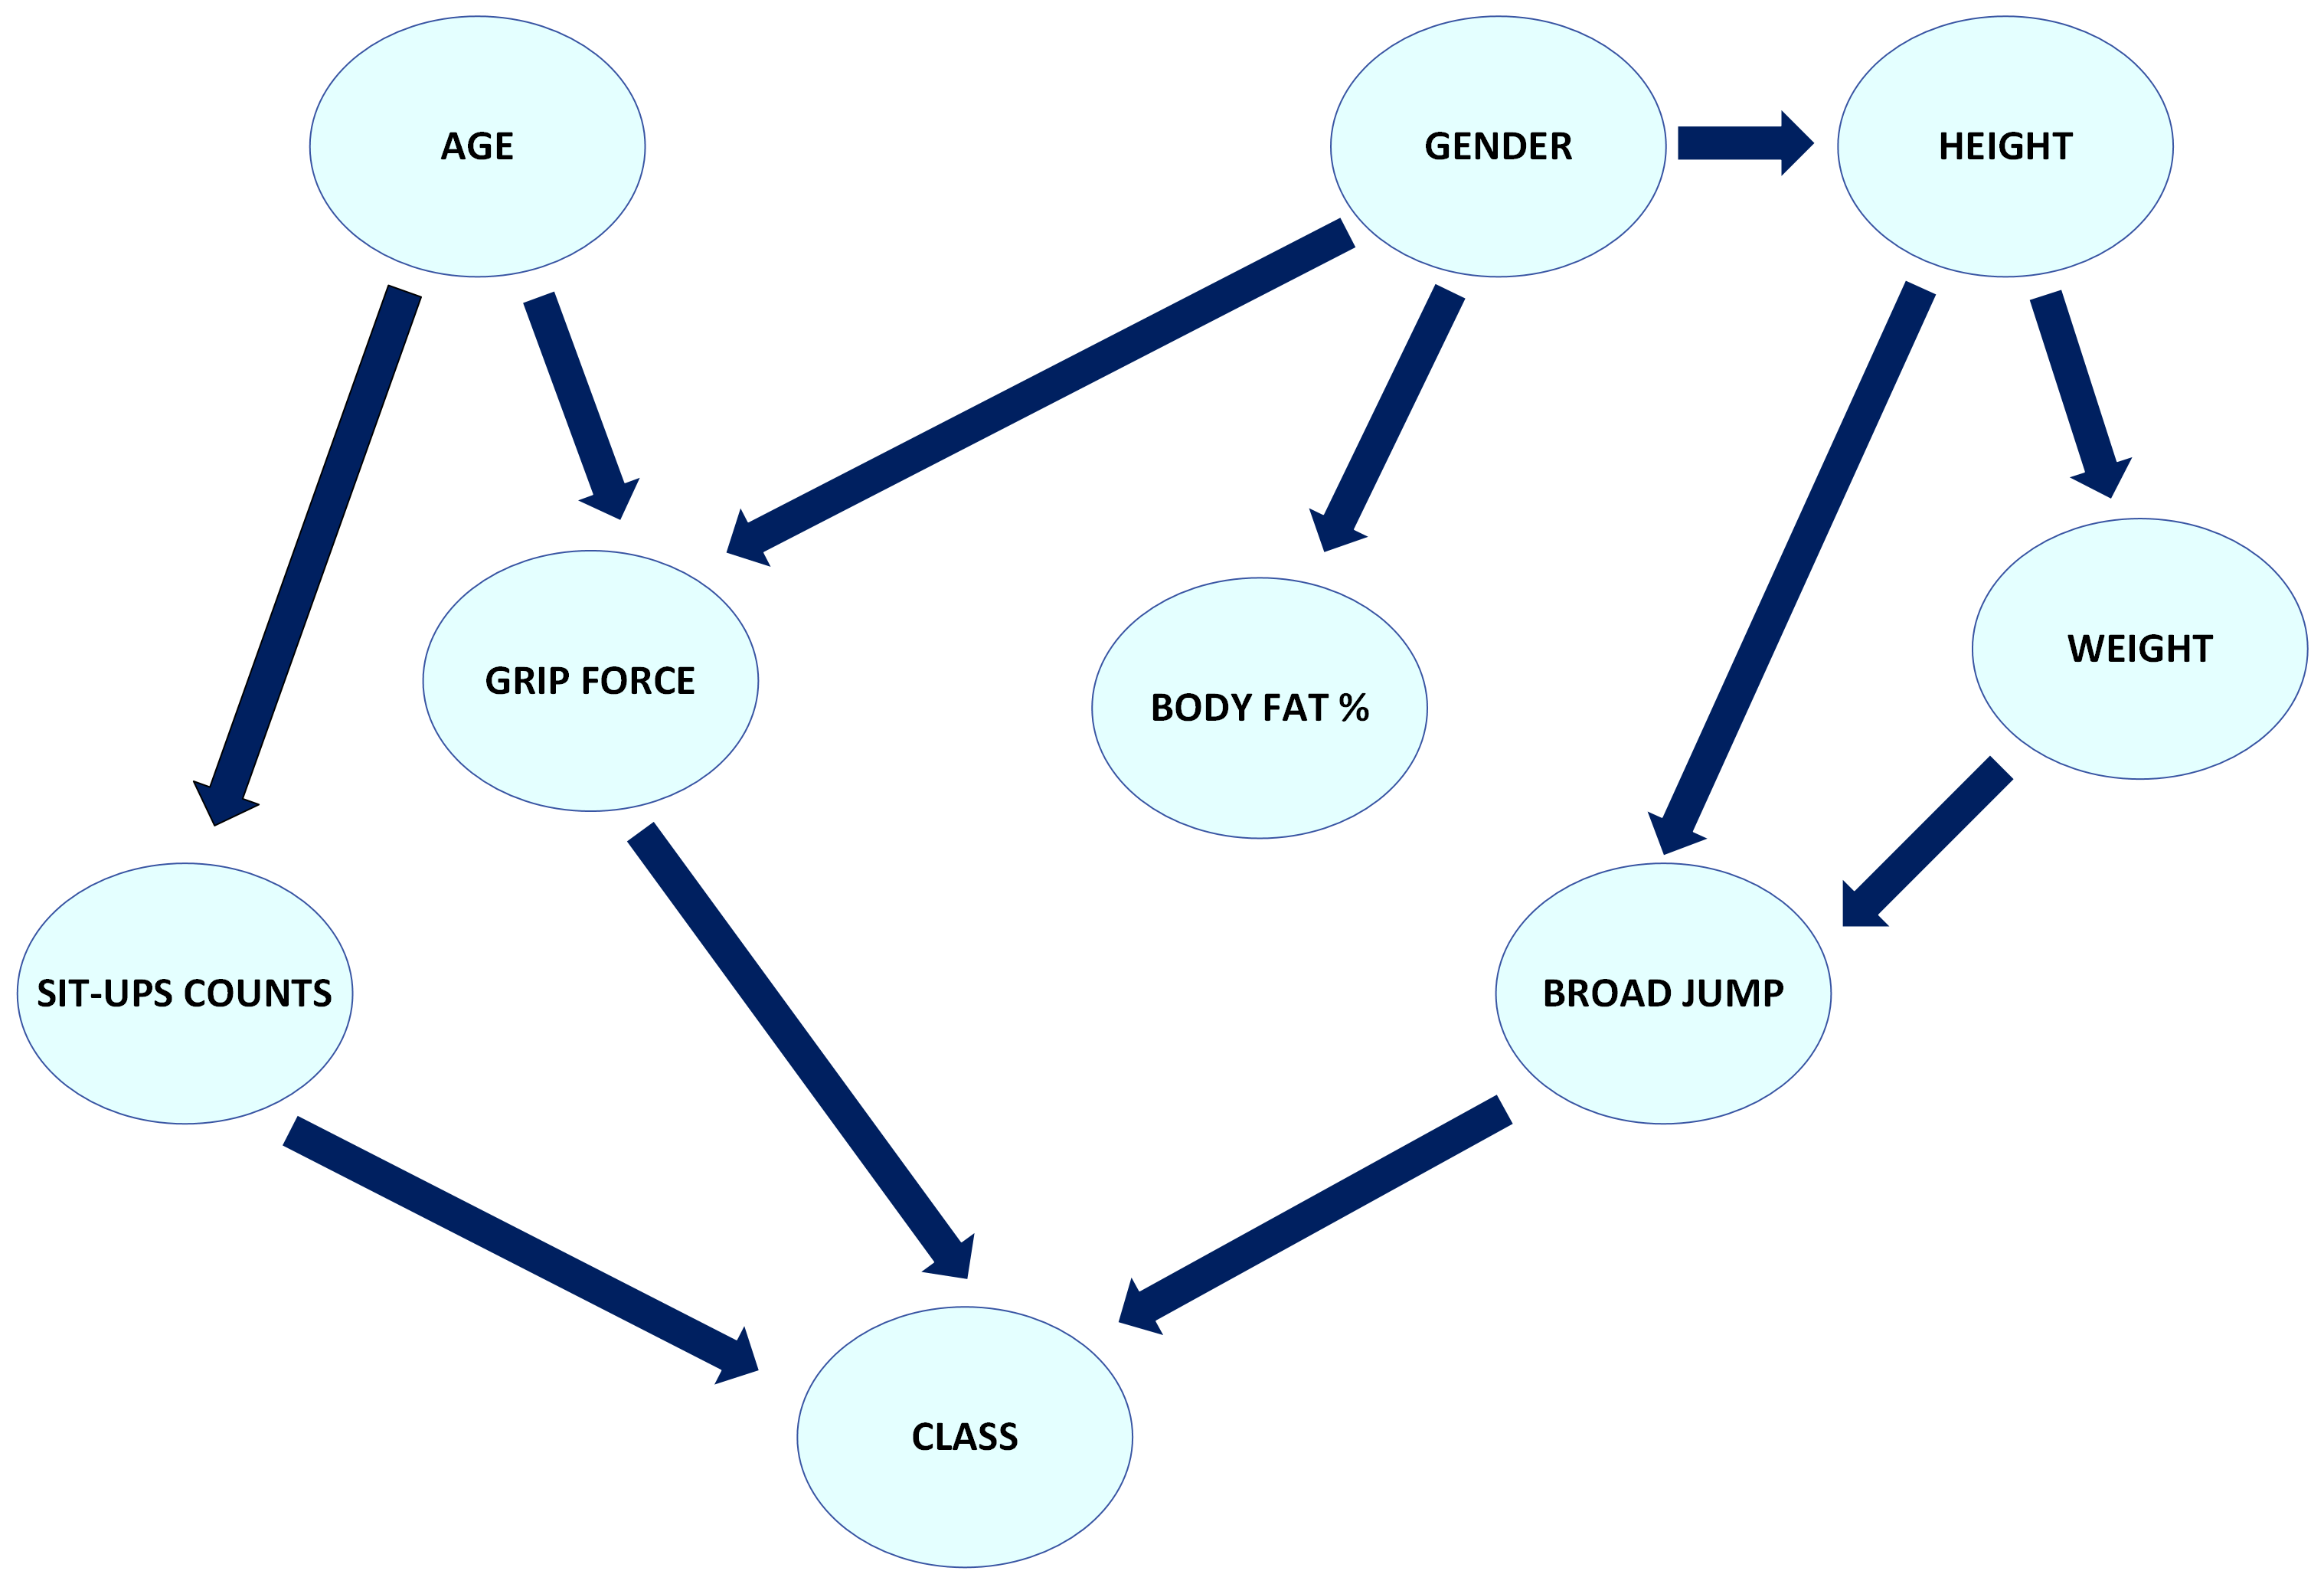

## Computing probabilities
The conditional probabilities are computed from the discretized dataset obtained through clustering.<br> The conditional probability formulas are applyed in a cycle using all the possible values of the events, in order to compute the probability matrix that is necessary to create the Bayesian Network.


In [ ]:
# number of samples that we are working with 
n = dataset.shape[0]

# starting from age and gender that are independent from the rest of the columns
p_gender = np.zeros((2,1))
p_gender_1 = sum(dataset["gender"]) / n
p_gender_0 = 1 - p_gender_1

p_age = np.zeros((3,1))
for i in range(0,3,1):
  p_age[i] = sum(dataset["age"]==i) / n 
#test print to be sure that probabilities sum to 1
#print(sum(p_age)) 

# columns with only one parent

# height_cm has ony one parent that is gender
# so gender is the only event conditioning height_cm
p_height = np.zeros((3,2))
for i in range(0,2,1):
  for j in range(0,3,1):
    p_height[j,i] = sum( (dataset["gender"]==i) & (dataset["height_cm"]==j) ) / sum(dataset["gender"]==i)
#test print to be sure that probabilities sum to 1
#print(sum(p_height)) 

# body fat_% has ony one parent that is gender
# so gender is the only event conditioning body fat_%
p_fat = np.zeros((3,2))
for j in range(0,3,1):
  for i in range(0,2,1):
    p_fat[j,i] = sum( (dataset["gender"]==i) & (dataset["body fat_%"]==j) ) / sum(dataset["gender"]==i)
#test print to be sure that probabilities sum to 1
#print(sum(p_fat)) 

# sit-ups counts has ony one parent that is age
# so age is the only event conditioning sit-ups counts
p_sit_ups = np.zeros((3,3))
for j in range(0,3,1):
  for i in range(0,3,1):
    p_sit_ups[j,i] = sum( (dataset["age"]==i) & (dataset["sit-ups counts"]==j) ) / sum(dataset["age"]==i)
#test print to be sure that probabilities sum to 1
#print(sum(p_sit_ups)) 

# weight_kg has ony one parent that is height_cm
# so height_cm is the only event conditioning weight_kg
p_weight = np.zeros((3,3))
for j in range(0,3,1):
  for i in range(0,3,1):
    p_weight[j,i] = sum( (dataset["height_cm"]==i) & (dataset["weight_kg"]==j) ) / sum(dataset["height_cm"]==i)
#test print to be sure that probabilities sum to 1
#print(sum(p_weight)) 

In [ ]:
# now the columns with two parents

# gripForce has two parent that is age and sex
# so age and sex will condition gripForce
p_gripForce = np.zeros((3,6))
for j in range(0,3,1):
  for i in range(0,2,1):
    for k in range(0,3,1):
      p_gripForce[k,i+2*j] = sum( (dataset["gender"]==i) & (dataset["gripForce"]==k) & (dataset["age"]==j) ) / sum((dataset["gender"]==i) & (dataset["age"]==j)  )
#test print to be sure that probabilities sum to 1
#print(sum(p_gripForce))

# broad jump_cm has two parent that is weight_kg and height_cm
# so weight_kg and height_cm will condition broad jump_cm
p_jump = np.zeros((3,9))
for j in range(0,3,1):
  for i in range(0,3,1):
    for k in range(0,3,1):
      p_jump[k,i+3*j] = sum( (dataset["weight_kg"]==i) & (dataset["broad jump_cm"]==k) & (dataset["height_cm"]==j) ) / sum((dataset["weight_kg"]==i) & (dataset["height_cm"]==j)  )
#test print to be sure that probabilities sum to 1
#print(sum(p_jump))

In [ ]:
# class has three parents: broad jump_cm, gripForce and sit-ups counts
# so broad jump_cm, gripForce and sit-ups counts will condition class distribution
p_class = np.zeros((4,27))
for j in range(0,3,1):
  for i in range(0,3,1):
    for k in range(0,4,1):
      for l in range(0,3,1):
        p_class[k,i+3*j+9*l] = sum( (dataset["broad jump_cm"]==i) & (dataset["class"]==k) & (dataset["gripForce"]==j) & (dataset["sit-ups counts"]==l) ) / sum((dataset["broad jump_cm"]==i) & (dataset["gripForce"]==j) & (dataset["sit-ups counts"]==l)  )
#test print to be sure that probabilities sum to 1
#print(sum(p_class))

The Bayesian Network is finally generated using the *pgmpy* library.

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# Defining the network structure
body_model = BayesianNetwork([('Age','Grip'),('Age','Sit count'),('Grip','Class'),('Sit count','Class'),('Gender','Grip'),('Gender','Height'),('Height','Weight'),('Height','Jump'),('Weight','Jump'),('Jump','Class'),('Gender','Body fat')])
gen_cpd=TabularCPD('Gender',2,[[p_gender_0],[p_gender_1]])
age_cpd=TabularCPD('Age',3,p_age)
fat_cpd=TabularCPD('Body fat',3,p_fat,evidence=['Gender'],evidence_card=[2])
sit_cpd=TabularCPD('Sit count',3,p_sit_ups,evidence=['Age'],evidence_card=[3])
gri_cpd=TabularCPD('Grip',3,p_gripForce,evidence=['Age','Gender'],evidence_card=[3,2])
hei_cpd=TabularCPD('Height',3,p_height,evidence=['Gender'],evidence_card=[2])
wei_cpd=TabularCPD('Weight',3,p_weight,evidence=['Height'],evidence_card=[3])
jum_cpd=TabularCPD('Jump',3,p_jump,evidence=['Height','Weight'],evidence_card=[3,3])
cla_cpd=TabularCPD('Class',4,p_class,evidence=['Sit count','Grip','Jump'],evidence_card=[3,3,3])

body_model.add_cpds(gen_cpd,age_cpd,fat_cpd,sit_cpd,gri_cpd,hei_cpd,wei_cpd,jum_cpd,cla_cpd)

print("Checking if the model is well-defined:",body_model.check_model())
print()
print("Printing probability tables:")
print(gen_cpd)
print(age_cpd)
print(fat_cpd)
print(sit_cpd)
print(gri_cpd)
print(hei_cpd)
print(wei_cpd)
print(jum_cpd)
print(cla_cpd)

Checking if the model is well-defined: True

Printing probability tables:
+-----------+----------+
| Gender(0) | 0.632196 |
+-----------+----------+
| Gender(1) | 0.367804 |
+-----------+----------+
+--------+----------+
| Age(0) | 0.506085 |
+--------+----------+
| Age(1) | 0.252221 |
+--------+----------+
| Age(2) | 0.241693 |
+--------+----------+
+-------------+---------------------+---------------------+
| Gender      | Gender(0)           | Gender(1)           |
+-------------+---------------------+---------------------+
| Body fat(0) | 0.4863588047714657  | 0.07511165245635404 |
+-------------+---------------------+---------------------+
| Body fat(1) | 0.43155781268453997 | 0.4468128298822574  |
+-------------+---------------------+---------------------+
| Body fat(2) | 0.08208338254399433 | 0.47807551766138856 |
+-------------+---------------------+---------------------+
+--------------+-----+---------------------+
| Age          | ... | Age(2)              |
+--------------+-

Some procedures on a Bayesian Network using pgmpy are *get_children, get_parents, get_leaves, get_roots, is_dconnected*.<br>
The last one returns True if there is an active trail (i.e. d-connection) between start and end node. 

In [ ]:
body_model.get_children('Age')

['Grip', 'Sit count']

In [ ]:
body_model.get_parents('Class')

['Grip', 'Sit count', 'Jump']

In [ ]:
body_model.get_leaves()

['Class', 'Body fat']

In [ ]:
body_model.get_roots()

['Age', 'Gender']

In [ ]:
body_model.is_dconnected('Age','Grip')

True

# Exact inference and Queries
Variable Elimination, an exact inference algorithm, is applied over our Bayesian Network.<br>
More formally, for each variable $X_i$ (ordered according to $O$):


*   Multiply all factors $Φ_i$ containing $X_i$
*   Marginalize out $X_i$ to obtain a new factor $τ$
*   Replace the factors $Φ_i$ with $τ$

The inference model resulting from Variable Elimination is used to answer the following queries.



In [ ]:
body_inference = VariableElimination(body_model)
print('P(Age)')
q_0 = body_inference.query(['Age'])
print(q_0)

P(Age)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------+------------+
| Age    |   phi(Age) |
+========+============+
| Age(0) |     0.5061 |
+--------+------------+
| Age(1) |     0.2522 |
+--------+------------+
| Age(2) |     0.2417 |
+--------+------------+


As first query, we can infer Class given the evidence of Age being old (class 2). This is an example of Causal Reasoning (prediction).

In [ ]:
q_1=body_inference.query(['Class'],{'Age':2})
print('P(Class|Age=Old)')
print(q_1)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

P(Class|Age=Old)
+----------+--------------+
| Class    |   phi(Class) |
+==========+==============+
| Class(0) |       0.4703 |
+----------+--------------+
| Class(1) |       0.2439 |
+----------+--------------+
| Class(2) |       0.1637 |
+----------+--------------+
| Class(3) |       0.1221 |
+----------+--------------+


Since Age is one of the parents of Grip force, we wanted to se how the grip force distribution changes with respect to the age.<br>

*  If the subject is old (age = 2) then it is likely to have a weaker grip (the 2 
lower intervals have a similar probability around 43%).<br>
*  If the subject is young (age = 0) then it is more likely to have a stronger grip(the highest value has an increased probability around 31%).

In [ ]:
q_2=body_inference.query(['Grip'],{'Age':2})
q_3=body_inference.query(['Grip'],{'Age':0})
print('P(GripForce|Age=Old)')
print(q_2)
print()
print('P(GripForce|Age=Young)')
print(q_3) 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

P(GripForce|Age=Old)
+---------+-------------+
| Grip    |   phi(Grip) |
+=========+=============+
| Grip(0) |      0.4228 |
+---------+-------------+
| Grip(1) |      0.4522 |
+---------+-------------+
| Grip(2) |      0.1250 |
+---------+-------------+

P(GripForce|Age=Young)
+---------+-------------+
| Grip    |   phi(Grip) |
+=========+=============+
| Grip(0) |      0.3444 |
+---------+-------------+
| Grip(1) |      0.3420 |
+---------+-------------+
| Grip(2) |      0.3136 |
+---------+-------------+


Conditioning jump with body fat even if it is not one of its parents, to show that jump and body fat are indipendent.<br> This is proven by the two tables (the first is conditioned with body fat, while the second one does not).

In [ ]:
print('P(Jump|Body fat = high, Gender = woman)')
q_4=body_inference.query(['Jump'],{'Body fat':2, 'Gender':1})
print(q_4)
print()
print('P(Jump|Gender = woman)')
q_5=body_inference.query(['Jump'],{'Gender':1})
print(q_5)

P(Jump|Body fat = high, Gender = woman)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+---------+-------------+
| Jump    |   phi(Jump) |
+=========+=============+
| Jump(0) |      0.4208 |
+---------+-------------+
| Jump(1) |      0.4305 |
+---------+-------------+
| Jump(2) |      0.1487 |
+---------+-------------+

P(Jump|Gender = woman)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+---------+-------------+
| Jump    |   phi(Jump) |
+=========+=============+
| Jump(0) |      0.4208 |
+---------+-------------+
| Jump(1) |      0.4305 |
+---------+-------------+
| Jump(2) |      0.1487 |
+---------+-------------+


Since Age is one of the parents of Grip force and Sit count, we wanted to see how these distributions change with respect to age, using only one query.
*  If the subject is old then it is likely to have a weaker grip and lower sit count.
*  If the subject is young then it is more likely to have a stronger grip and higher sit count.<br>

This is an example of Intercausal Reasoning (explaining why).

In [ ]:
# Conjunctive queries
print('P(Sit count, Grip force|Age = old)')
q_6=body_inference.query(['Sit count','Grip'],{'Age':2})
print(q_6)
print()
print('P(Sit count, Grip force|Age = young)')
q_7=body_inference.query(['Sit count','Grip'],{'Age':0})
print(q_7)

P(Sit count, Grip force|Age = old)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+---------+--------------+-----------------------+
| Grip    | Sit count    |   phi(Grip,Sit count) |
+=========+==============+=======================+
| Grip(0) | Sit count(0) |                0.2095 |
+---------+--------------+-----------------------+
| Grip(0) | Sit count(1) |                0.1801 |
+---------+--------------+-----------------------+
| Grip(0) | Sit count(2) |                0.0332 |
+---------+--------------+-----------------------+
| Grip(1) | Sit count(0) |                0.2241 |
+---------+--------------+-----------------------+
| Grip(1) | Sit count(1) |                0.1927 |
+---------+--------------+-----------------------+
| Grip(1) | Sit count(2) |                0.0355 |
+---------+--------------+-----------------------+
| Grip(2) | Sit count(0) |                0.0619 |
+---------+--------------+-----------------------+
| Grip(2) | Sit count(1) |                0.0533 |
+---------+--------------+-----------------------+
| Grip(2) | Sit count(2) |     

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+---------+--------------+-----------------------+
| Grip    | Sit count    |   phi(Grip,Sit count) |
+=========+==============+=======================+
| Grip(0) | Sit count(0) |                0.0233 |
+---------+--------------+-----------------------+
| Grip(0) | Sit count(1) |                0.1147 |
+---------+--------------+-----------------------+
| Grip(0) | Sit count(2) |                0.2064 |
+---------+--------------+-----------------------+
| Grip(1) | Sit count(0) |                0.0231 |
+---------+--------------+-----------------------+
| Grip(1) | Sit count(1) |                0.1139 |
+---------+--------------+-----------------------+
| Grip(1) | Sit count(2) |                0.2050 |
+---------+--------------+-----------------------+
| Grip(2) | Sit count(0) |                0.0212 |
+---------+--------------+-----------------------+
| Grip(2) | Sit count(1) |                0.1045 |
+---------+--------------+-----------------------+
| Grip(2) | Sit count(2) |     

Conditioning Grip force with Gender, one of its parents, to show that they are related.<br>
This is proven by the two tables (the first is conditioned with gender male, the second one with gender female).

In [ ]:
print('P(Grip force|Gender = man)')
q_8=body_inference.query(['Grip'],{'Gender':0})
print(q_8)
print()
print('P(Grip force|Gender = woman)')
q_9=body_inference.query(['Grip'],{'Gender':1})
print(q_9)

P(Grip force|Gender = man)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+---------+-------------+
| Grip    |   phi(Grip) |
+=========+=============+
| Grip(0) |      0.0522 |
+---------+-------------+
| Grip(1) |      0.5239 |
+---------+-------------+
| Grip(2) |      0.4239 |
+---------+-------------+

P(Grip force|Gender = woman)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+---------+-------------+
| Grip    |   phi(Grip) |
+=========+=============+
| Grip(0) |      0.9058 |
+---------+-------------+
| Grip(1) |      0.0937 |
+---------+-------------+
| Grip(2) |      0.0005 |
+---------+-------------+


Given the evidence of grip force and its parent age, the tables shows that it is possible to infer the value of the other parent of grip force: gender.

In [ ]:
print('P(Gender|Age = mid, Grip force = high)')
q_10=body_inference.query(['Gender'],{'Age':1, 'Grip':2})
print(q_10)
print()
print('P(Gender|Age = old, Grip force = high)')
q_11=body_inference.query(['Gender'],{'Age':2, 'Grip':2})
print(q_11)

P(Gender|Age = mid, Grip force = high)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.9979 |
+-----------+---------------+
| Gender(1) |        0.0021 |
+-----------+---------------+

P(Gender|Age = old, Grip force = high)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        1.0000 |
+-----------+---------------+
| Gender(1) |        0.0000 |
+-----------+---------------+


Inferring the gender using the evidence of its child body fat % and its descendants class and broad jump. This is an example of Evidential Reasoning (explanation).

In [ ]:
print('P(Gender|Class = worst, Broad jump = low, Body fat = high)')
q_12=body_inference.query(['Gender'],{'Class':0, 'Jump':0, 'Body fat':2})
print(q_12)
print()
print('P(Gender|Class = worst, Broad jump = mid, Body fat = low)')
q_13=body_inference.query(['Gender'],{'Class':0, 'Jump':1, 'Body fat':0})
print(q_13)
print()
print('P(Gender|Class = fittest, Broad jump = low, Body fat = high)')
q_14=body_inference.query(['Gender'],{'Class':3, 'Jump':0, 'Body fat':2})
print(q_14)
print()
print('P(Gender|Class = fittest, Broad jump = mid, Body fat = low)')
q_15=body_inference.query(['Gender'],{'Class':3, 'Jump':1, 'Body fat':0})
print(q_15)

P(Gender|Class = worst, Broad jump = low, Body fat = high)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.0867 |
+-----------+---------------+
| Gender(1) |        0.9133 |
+-----------+---------------+

P(Gender|Class = worst, Broad jump = mid, Body fat = low)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.9556 |
+-----------+---------------+
| Gender(1) |        0.0444 |
+-----------+---------------+

P(Gender|Class = fittest, Broad jump = low, Body fat = high)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.0397 |
+-----------+---------------+
| Gender(1) |        0.9603 |
+-----------+---------------+

P(Gender|Class = fittest, Broad jump = mid, Body fat = low)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.7880 |
+-----------+---------------+
| Gender(1) |        0.2120 |
+-----------+---------------+


# Approximate Inference
It is possible to check if the created model is a correct representation of the data dependencies. <br>
A family of techniques which can be useful are the sampling methods. In this case, rejection sampling, likelihood weighting and Gibbs sampling will be used.<br>
<br>
As an example, we want to infer the probability of a person being young (youngest age is class 0) knowing that he/she reached the best results in the sit-ups' count (best sit ups is class 2) and that belongs to the worst class of body performance (class 0).<br>

###Reference probabilities
In order to compare the sampling methods, we need to find a reference.<br>
One could be the probability values provided by the Bayesian Network constructed.


In [ ]:
# Exact values of queries (for comparison)

p_age= body_inference.query(['Age'],{'Sit count':2,'Class':0}).values[0]

p_grip = body_inference.query(['Grip'],{'Sit count':2,'Class':0}).values[0] 

print("Probability of Age = 0 given the Evidence Sit count = 2 and Class = 0:", round(p_age,4))
print("Probability of Grip force = 0 given the Evidence Sit count = 2 and Class = 0:", round(p_grip,4))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Probability of Age = 0 given the Evidence Sit count = 2 and Class = 0: 0.7284
Probability of Grip force = 0 given the Evidence Sit count = 2 and Class = 0: 0.251


Or the true probability manually calculated from the dataset.

In [ ]:
#true probability of P(Age=0|Class=0, Sit ups=2)


true_p_age = sum( (dataset["age"]==0) & (dataset["class"]==0) & (dataset["sit-ups counts"]==2) ) / sum((dataset["class"]==0) & (dataset["sit-ups counts"]==2)  )
# to test the calculations
print("True probability of Age = 0 given the Evidence:", round(true_p_age,4))

true_p_grip = sum( (dataset["gripForce"]==0) & (dataset["class"]==0) & (dataset["sit-ups counts"]==2) ) / sum((dataset["class"]==0) & (dataset["sit-ups counts"]==2)  )
# to test the calculations
print("True probability of Grip = 0 force given the Evidence:", round(true_p_grip,4))

True probability of Age = 0 given the Evidence: 0.7624
True probability of Grip = 0 force given the Evidence: 0.0809


###Sampling
In Rejection sampling, samples are firstly generated and then selected according to the evidence we want to study (the others are rejected). This process is wasteful in
the way it handles evidence: it generates samples that are inconsistent
with our evidence; they are ultimately rejected without contributing to
the estimate.<br>
Differently, in Likelihood weighting variables are sampled and evidence is used to update the weights. The weights reflect the probability that a sample would not be rejected.<br>
<br> 
A method which compares the result of the different Sampling methods, depending on the number of samples selected, can be created.<br>
First of all, the probabilities of Rejection sampling and Likelihood weighting are computed using different function. This is because the latter requires the weight for each sample.<br>

In [ ]:
# Now switch to sampling methods

inference = BayesianModelSampling(body_model)

evidence = [State('Sit count', 2),State('Class', 0)]
verbose = False

def prob_LW(samples,variable):
    c={0:1,1:0, 2:0}
    samples[variable]=samples[variable].map(c)
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

def prob_RS(samples,variable):
    c={0:1,1:0, 2:0}
    samples[variable]=samples[variable].map(c)
    return np.mean(samples[variable], axis=0)

def relative_error(exact_value,approx_value):
    return np.absolute((exact_value-approx_value)/exact_value)

def absolute_error(exact_value,approx_value):
    return np.absolute(exact_value-approx_value)

*Pgmpy* library provides a class to create Gibbs sampling from the Bayesian Network model. Sample function generates samples. <br>
Anyway, it does not provide the evidence evaluation, so it is not possible to automatically infer using samples.


In [ ]:
gibbs_chain_body = GibbsSampling(body_model)

gibbs_chain_body.sample(size=10)

/usr/local/lib/python3.7/dist-packages/pgmpy/sampling/Sampling.py:433: RuntimeWarning: invalid value encountered in true_divide
  kernel[tup] = prod_cpd_reduced.values / sum(prod_cpd_reduced.values)


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."
/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."
/usr/local/lib/python3.7/dist-packages/pgmpy/utils/mathext.py:84: UserWarning: Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
  f"Probability values don't exactly sum to 1. Differ by: {error}. Adjusting values."


,Age,Grip,Sit count,Class,Gender,Height,Weight,Jump,Body fat
0,2,2,1,0,0,2,2,0,0
1,1,2,1,2,0,2,1,2,0
2,0,1,2,2,0,1,0,1,1
3,0,1,1,3,0,1,1,2,0
4,1,1,2,2,0,1,1,1,0
5,1,2,2,0,0,1,1,2,1
6,0,1,1,0,0,2,2,2,1
7,2,1,0,0,0,2,1,2,0
8,2,2,1,2,0,1,1,0,0
9,1,2,1,2,0,1,0,1,1


The experiment is useful to provide different probabilities of the sampling methods using different samples sizes. <br>
Obviously, the higher the sample size, the more expensive is the computation while inference is more accurate.

In [ ]:
def run_experiment(sample_size):
    # Sample
    samples_LW = inference.likelihood_weighted_sample(evidence = evidence, size=sample_size)
    samples_RS = inference.rejection_sample(evidence=evidence, size=sample_size)
    #samples_GS = gibbs_chain_body.sample(size=sample_size)
    #samples_GS = samples_GS[samples_GS['Sit count']==2]
    #samples_GS = samples_GS[samples_GS['Class']==0]

    verbose = False
    
    # Statistics
    p_age_LW=prob_LW(samples_LW,'Age')
    p_grip_LW=prob_LW(samples_LW,'Grip')
    p_age_RS=prob_RS(samples_RS, 'Age')
    p_grip_RS=prob_RS(samples_RS, 'Grip') 
    #p_age_GS=prob_RS(samples_GS, 'Age')
    #p_grip_GS=prob_RS(samples_GS, 'Grip')

    # Reporting
    if(verbose):
        print()
        print("P(Age=0|Class=0, Sit ups=2) =", round(p_age,3))
        print("With Rejection Sampling after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, p_age_RS, absolute_error(p_age,p_age_RS)*100))
        print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size,  p_age_LW, absolute_error(p_age, p_age_LW)*100))
        #print("With Gibbs sampling after %d samples: %.3f (error = %.2f percent)" 
        #      % (sample_size,  p_age_GS, absolute_error(p_age, p_age_GS)*100))
        print()
        print("P(Grip=0|Class=0, Sit ups=2) =", round(p_grip,3))
        print("With Rejection Sampling after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, p_grip_RS, absolute_error(p_grip,p_grip_RS)*100))
        print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, p_grip_LW, absolute_error(p_grip,p_grip_LW)*100))
        #print("With Gibbs sampling after %d samples: %.3f (error = %.2f percent)" 
        #      % (sample_size,  p_grip_GS, absolute_error(p_grip, p_grip_GS)*100))
        print()
        print(samples_RS)
        print(samples_LW)
        #print(samples_GS)
        print()
    
    # Return results
    return np.array([(sample_size, 
                      p_age_RS, absolute_error(p_age,p_age_RS),
                      p_age_LW, absolute_error(p_age,p_age_LW),
                      #p_age_GS, absolute_error(p_age,p_age_GS),
                      p_grip_RS, absolute_error(p_grip,p_grip_RS),
                      p_grip_LW, absolute_error(p_grip,p_grip_LW))],
                      #p_grip_GS, absolute_error(p_grip,p_grip_GS))], 
                    dtype=[('sample_size', '<i8'), 
                           ('p_age_RS', '<f8'),('e_p_age_RS', '<f8'),
                           ('p_age_LW', '<f8'),('e_p_age_LW', '<f8'),
                           #('p_age_GS', '<f8'),('e_p_age_GS', '<f8'),
                           ('p_grip_RS', '<f8'),('e_p_grip_RS', '<f8'),
                           ('p_grip_LW', '<f8'),('e_p_grip_LW', '<f8')])
                           #('p_grip_GS', '<f8'),('e_p_grip_GS', '<f8')])

In [ ]:
results = np.array([],dtype=[('sample_size', '<i8'), 
                           ('p_age_RS', '<f8'),('e_p_age_RS', '<f8'),
                           ('p_age_LW', '<f8'),('e_p_age_LW', '<f8'),
                           #('p_age_GS', '<f8'),('e_p_age_GS', '<f8'),
                           ('p_grip_RS', '<f8'),('e_p_grip_RS', '<f8'),
                           ('p_grip_LW', '<f8'),('e_p_grip_LW', '<f8')])
                           #('p_grip_GS', '<f8'),('e_p_grip_GS', '<f8')])
starting_size_=1 # from 10 sample points
final_size=5     # to 10^5 sample points
experiments=20 # 8 experiments

for size in np.logspace(starting_size_, final_size, num=experiments, dtype='<i8'):
    results=np.append(results,run_experiment(size))
    
print(results)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1274 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2069 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3359 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5455 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8858 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/14384 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/23357 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/37926 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/61584 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

[(    10, 0.7       , 2.84498150e-02, 0.78, 0.05155019, 0.1       , 0.15101413, 0.36, 0.10898587)
 (    16, 0.375     , 3.53449815e-01, 0.85, 0.12155019, 0.125     , 0.12601413, 0.15, 0.10101413)
 (    26, 0.92307692, 1.94627108e-01, 0.79, 0.06155019, 0.26923077, 0.01821663, 0.12, 0.13101413)
 (    42, 0.76190476, 3.34549470e-02, 0.8 , 0.07155019, 0.23809524, 0.0129189 , 0.12, 0.13101413)
 (    69, 0.75362319, 2.51733735e-02, 0.85, 0.12155019, 0.26086957, 0.00985543, 0.19, 0.06101413)
 (   112, 0.64285714, 8.55926721e-02, 0.81, 0.08155019, 0.25892857, 0.00791444, 0.26, 0.00898587)
 (   183, 0.69945355, 2.89962630e-02, 0.73, 0.00155019, 0.28415301, 0.03313887, 0.24, 0.01101413)
 (   297, 0.71717172, 1.12780978e-02, 0.79, 0.06155019, 0.24915825, 0.00185589, 0.23, 0.02101413)
 (   483, 0.72463768, 3.81213380e-03, 0.73, 0.00155019, 0.26915114, 0.018137  , 0.23, 0.02101413)
 (   784, 0.70408163, 2.43681823e-02, 0.74, 0.01155019, 0.24744898, 0.00356516, 0.27, 0.01898587)
 (  1274, 0.70643642

To compare the different sampling methods, plotting the results using the reference probabilities can be useful.<br>
As shown, using high sample sizes, the accuracy of the sampling methods are very high, approximating the reference probability. <br>
<br>
The true value of age is similar to the exact probability computed using Variable Elimination. It means that the Bayesian Network is a good approximation of the real relationship between these attributes of the dataset. <br>
On the other hand, the approximated value of grip force given the evidence is not so similar to the true value computed, so the model is not well representing the relationship between these three attributes.

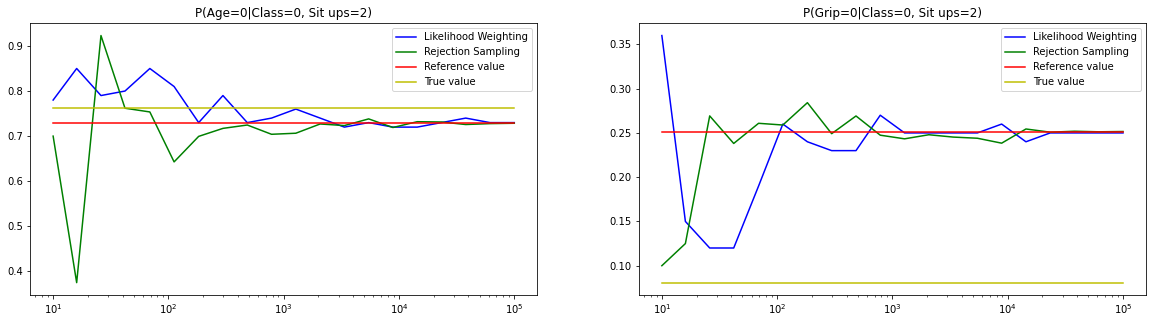

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('P(Age=0|Class=0, Sit ups=2)')
LWCplot, = plt.semilogx(results['sample_size'],results['p_age_LW'],'b',label="Likelihood Weighting")
RSCplot, = plt.semilogx(results['sample_size'],results['p_age_RS'],'g',label="Rejection Sampling")
#GSCplot, = plt.semilogx(results['sample_size'],results['p_age_GS'],'purple',label="Gibbs sampling")
VECplot, = plt.semilogx(results['sample_size'],p_age*np.ones(results.size),'r',label="Reference value")
TRUplot, = plt.semilogx(results['sample_size'],true_p_age*np.ones(results.size),'y',label="True value")
plt.legend(handles=[LWCplot,RSCplot,VECplot,TRUplot])
plt.subplot(122)
plt.title('P(Grip=0|Class=0, Sit ups=2)')
LWCplot, = plt.semilogx(results['sample_size'],results['p_grip_LW'],'b',label="Likelihood Weighting")
RSCplot, = plt.semilogx(results['sample_size'],results['p_grip_RS'],'g',label="Rejection Sampling")
#GSCplot, = plt.semilogx(results['sample_size'],results['p_grip_GS'],'purple',label="Gibbs sampling")
VECplot, = plt.semilogx(results['sample_size'],p_grip*np.ones(results.size),'r',label="Reference value")
TRUplot, = plt.semilogx(results['sample_size'],true_p_grip*np.ones(results.size),'y',label="True value")
plt.legend(handles=[LWCplot,RSCplot,VECplot,TRUplot])

plt.show()

The absolute error can confirm that using high samples sizes in sampling methods help to have a better approximation of the probability values.

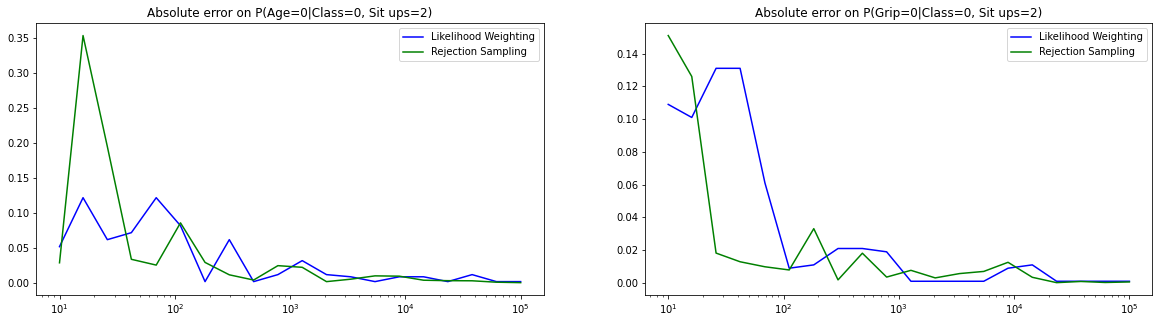

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Absolute error on P(Age=0|Class=0, Sit ups=2)')
ELWCplot, = plt.semilogx(results['sample_size'],results['e_p_age_LW'],'b',label="Likelihood Weighting")
ERSCplot, = plt.semilogx(results['sample_size'],results['e_p_age_RS'],'g',label="Rejection Sampling")
#EGSCplot, = plt.semilogx(results['sample_size'],results['e_p_age_GS'],'r',label="Gibbs Sampling")
plt.legend(handles=[ELWCplot,ERSCplot])
plt.subplot(122)
plt.title('Absolute error on P(Grip=0|Class=0, Sit ups=2)')
ELWCplot, = plt.semilogx(results['sample_size'],results['e_p_grip_LW'],'b',label="Likelihood Weighting")
ERSCplot, = plt.semilogx(results['sample_size'],results['e_p_grip_RS'],'g',label="Rejection Sampling")
#EGSCplot, = plt.semilogx(results['sample_size'],results['e_p_grip_GS'],'r',label="Gibbs Sampling")
plt.legend(handles=[ELWCplot,ERSCplot])
plt.show()

##Markov Blanket
In a Bayesian network, the Markov boundary of node A includes its parents, children and the other parents of all of its children. <br>
*Pgmpy* provides a function to automatically produce the Markov Blanket of a given node.


In [ ]:
f=body_model.get_markov_blanket('Grip')
f1=body_model.get_markov_blanket('Weight')
f2=body_model.get_markov_blanket('Body fat')

print('The Markov Blanket of Grip Force')
print(f)
print()
print('The Markov Blanket of Weight' )
print(f1)
print()
print('The Markov Blanket of Body fat' )
print(f2)

The Markov Blanket of Grip Force
['Age', 'Class', 'Jump', 'Sit count', 'Gender']

The Markov Blanket of Weight
['Height', 'Jump']

The Markov Blanket of Body fat
['Gender']


#Conclusion
*Pgmpy* library provides automatic methods to build probability tables that we found quite useful compared to manually construct them. <br>
Furthermore, it was helpful to calculate exact and approximate inference thanks to the built-in sampling methods that are otherwise tricky to manage. <br>

#Reference


*   https://pgmpy.org/
*   https://artint.info/2e/html/ArtInt2e.Ch8.S6.SS4.html
*   https://github.com/pgmpy/pgmpy/issues/1080
*   https://ermongroup.github.io/cs228-notes/inference/ve/

